In [26]:
import os
import glob
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

# **Converting audio samples into spectograms**

In [27]:
FRAME_LENGTH = 255
FRAME_STEP = 128

class Spectrogram():

  def __init__(self):
    pass

  """
    Returns the spectrogram of the waveform.
  """
  def get_spectrogram(self, waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  """
    Returns the plot data of the spectrogram.
  """
  def plot_spectrogram(self, spectrogram, ax):
    if (len(spectrogram.shape) > 2):
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

<div style="font-family: Arial, sans-serif;">
  <h2 style="color: #f39c12; font-size: 24px;">interpretation:</h2>
  <p style="color: #d35400; font-size: 18px; line-height: 1.6;">
   Transforme l'audio en image 2D (spectrogramme) Avec des paramètres optimisés pour capturer les motifs des défauts de moteur
  </p>
</div>


In [28]:
BATCH_SIZE = 32
OUTPUT_SEQUENCE_LENGTH = 16000
TRAIN_DATASET = '/kaggle/input/electrical-motor-operational-state-sound-data/IDMT-ISA-ELECTRIC-ENGINE/test_cut'
VALIDATION_DATASET = '/kaggle/input/electrical-motor-operational-state-sound-data/IDMT-ISA-ELECTRIC-ENGINE/train_cut'

class AudioDataLoader():

  def __init__(self):
    pass

  """
    Returns the training dataset.
  """
  def get_training_dataset_and_class_names(self):
    train_ds = tf.keras.utils.audio_dataset_from_directory(
      TRAIN_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    class_names = train_ds.class_names
    train_ds = train_ds.map(self._squeeze, tf.data.AUTOTUNE)
    return train_ds, class_names

  """
    Returns the validation and test datasets.
  """
  def get_validation_and_test_datasets(self):
    validation_ds = tf.keras.utils.audio_dataset_from_directory(
      VALIDATION_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    validation_ds = validation_ds.map(self._squeeze, tf.data.AUTOTUNE)
    validation_ds, test_ds = self._get_test_dataset(validation_ds)

    return validation_ds, test_ds

  """
    Returns the test dataset.
  """
  def _get_test_dataset(self, validation_dataset):
    validation_dataset = validation_dataset.shard(num_shards=2, index=0)
    test_dataset = validation_dataset.shard(num_shards=2, index=1)
    return validation_dataset, test_dataset

  """
    Squeezes the waveform dimension.
  """
  def _squeeze(self, waveforms, labels):
    waveforms = tf.squeeze(waveforms, axis=-1)
    return waveforms, labels

<div style="font-family: Arial, sans-serif;">
  <h2 style="color: #f39c12; font-size: 24px;">Interprétation:</h2>
  <p style="color: #d35400; font-size: 18px; line-height: 1.6;">
    - <strong><code>BATCH_SIZE = 32</code></strong> : Nombre d'échantillons traités ensemble par itération.<br>
    - <strong><code>OUTPUT_SEQUENCE_LENGTH = 16000</code></strong> : Longueur des séquences audio en entrée (16 000 échantillons).<br><br>
    Le but est de préparer les données audio (chargement, prétraitement, division en ensembles) pour l'entraînement et l'évaluation du modèle. en utilisant  classe AudioDataLoader
  </p>
</div>


In [29]:
dataloader = AudioDataLoader()
train_ds, class_names = dataloader.get_training_dataset_and_class_names()
validation_ds, test_ds = dataloader.get_validation_and_test_datasets()

Found 2021 files belonging to 3 classes.
Found 357 files belonging to 3 classes.


In [30]:
print(class_names)

['engine1_good', 'engine2_broken', 'engine3_heavyload']


<div style="font-family: Arial, sans-serif;">
  <p><strong>engine1_good</strong> : Moteur en bon état. 👍</p>
  <p><strong>engine2_broken</strong> : Moteur cassé ou endommagé. 🔧</p>
  <p><strong>engine3_heavyload</strong> : Moteur sous une charge lourde. 🚫</p>
</div>


In [31]:
for waveforms, labels in train_ds.take(1):
  print(waveforms.shape)
  print(labels.shape)

(32, 16000)
(32,)


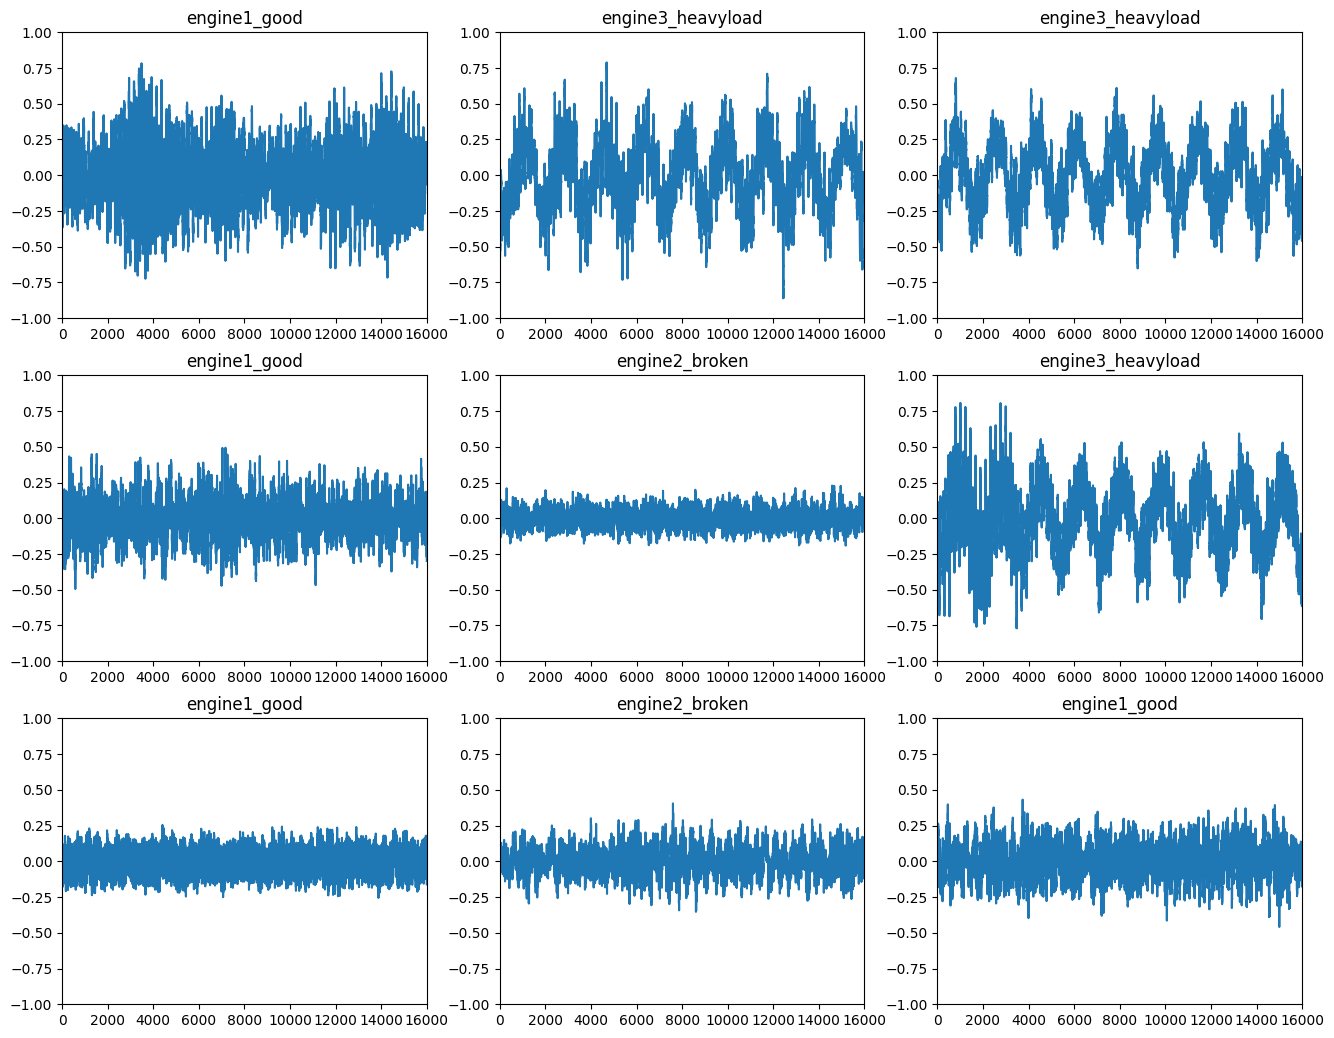

In [32]:
plt.figure(figsize=(16,9))
plt.subplots_adjust(bottom=-0.2)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.plot(waveforms[i].numpy())
  plt.title(class_names[labels[i]])
  plt.axis([0, 16000, -1, 1])

**Interprétation :**

- Les **formes d’onde seules** ne montrent pas bien les détails du son.  
- Les **spectrogrammes révèlent les fréquences**, ce qui est plus utile pour reconnaître des sons (comme le bruit d’un moteur cassé).  
- Les **modèles d’IA comprennent mieux les images** que les signaux bruts.  

👉 Donc, transformer les sons en spectrogrammes aide le modèle à mieux apprendre et prédire.


# **Generate Spectrograms from the Waveforms**

In [33]:
spec = Spectrogram()

In [34]:
for j in range(9):
  label = class_names[labels[j]]
  waveform = waveforms[j]
  spectrogram = spec.get_spectrogram(waveform)
  print(f"\nLabel: {label}")
  print(f"Spectrogram Shape: {spectrogram.shape}\n")

  display.display(display.Audio(waveform, rate=16000))


Label: engine1_good
Spectrogram Shape: (124, 129, 1)




Label: engine3_heavyload
Spectrogram Shape: (124, 129, 1)




Label: engine3_heavyload
Spectrogram Shape: (124, 129, 1)




Label: engine1_good
Spectrogram Shape: (124, 129, 1)




Label: engine2_broken
Spectrogram Shape: (124, 129, 1)




Label: engine3_heavyload
Spectrogram Shape: (124, 129, 1)




Label: engine1_good
Spectrogram Shape: (124, 129, 1)




Label: engine2_broken
Spectrogram Shape: (124, 129, 1)




Label: engine1_good
Spectrogram Shape: (124, 129, 1)



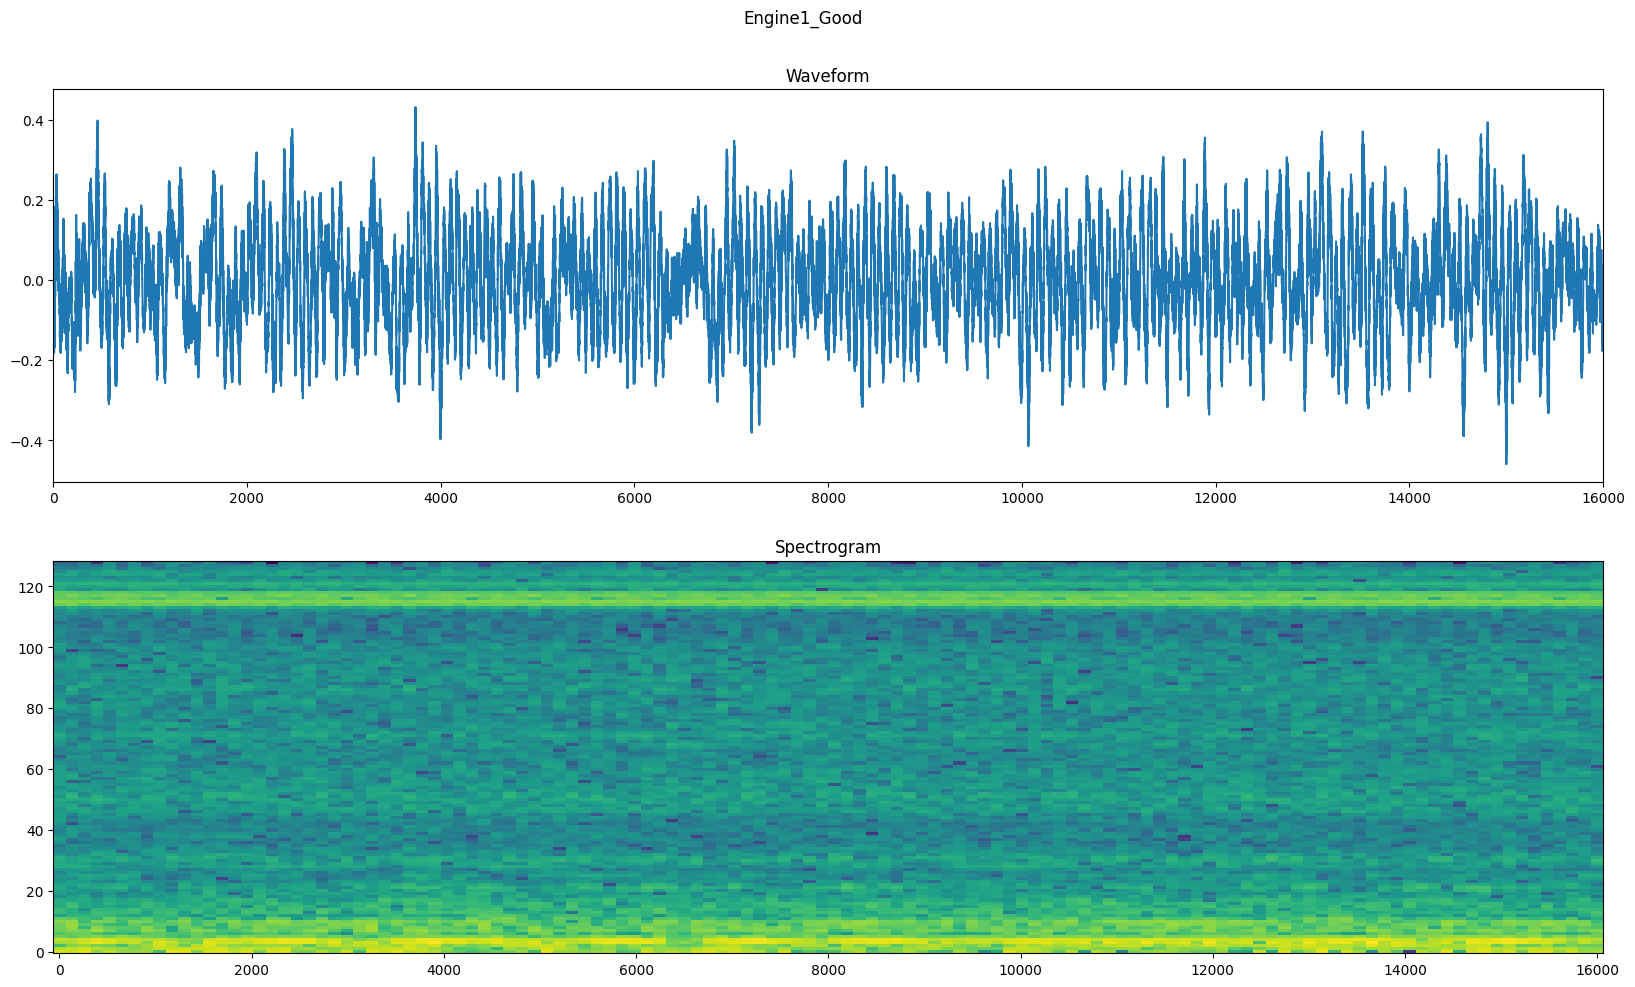

In [35]:
fig, axes = plt.subplots(2, figsize=(20, 8))
plt.subplots_adjust(bottom=-0.2)

timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

spec.plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# **Generate Spectrogram Datasets to be used in the CNN**

In [36]:
train_spectrogram_ds = train_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

validation_spectrogram_ds = validation_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_spectrogram_ds = test_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [37]:
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
  break

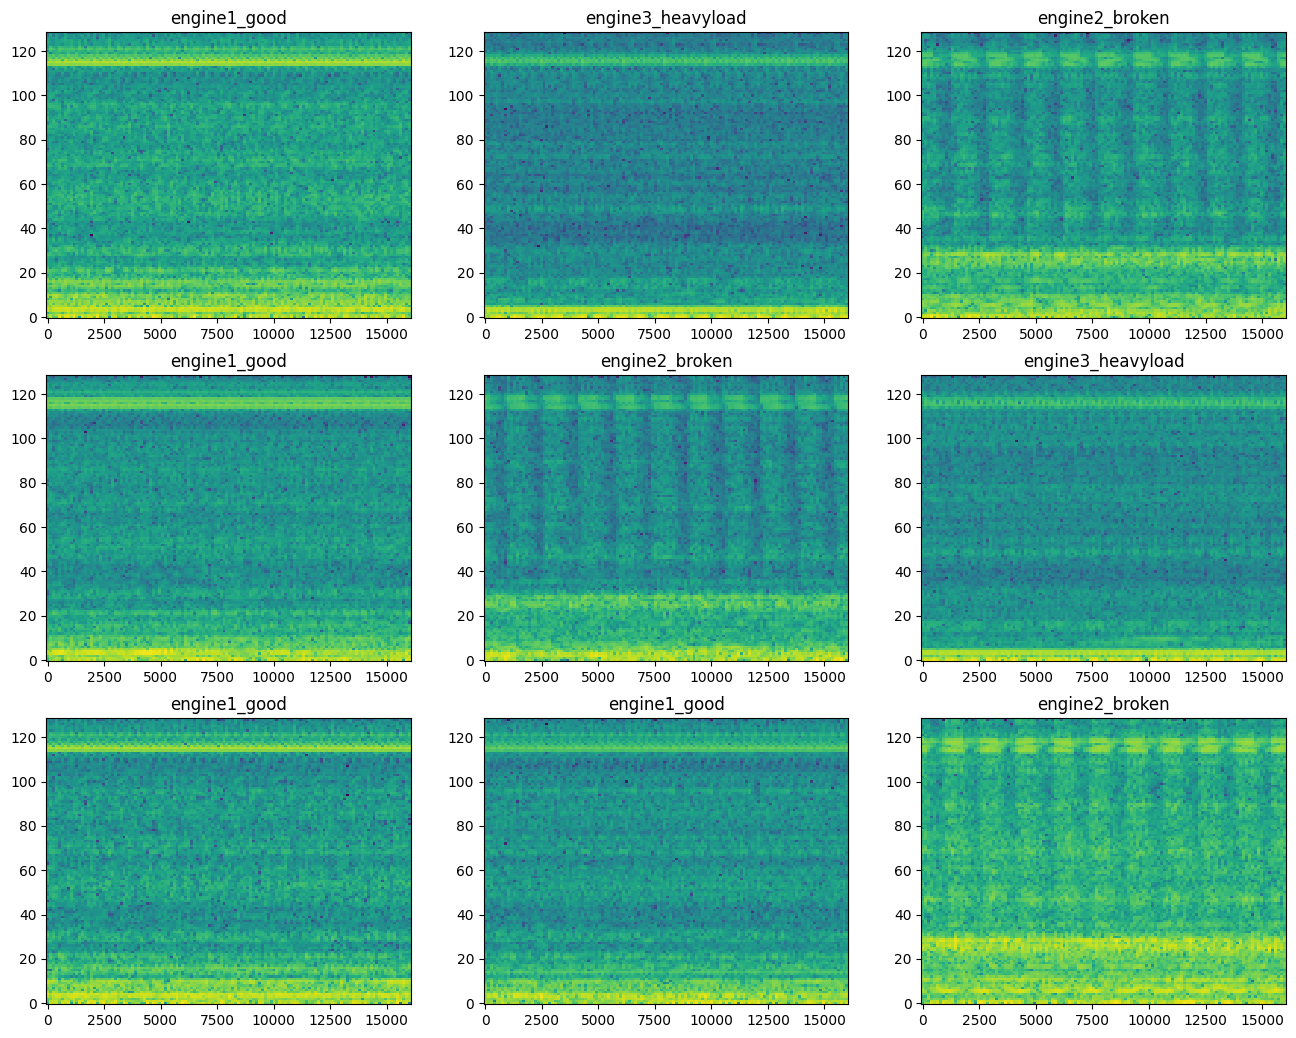

In [38]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_labels[i].numpy()])

plt.show()

**Interprétation :**

- Les **formes d’onde seules** ne montrent pas bien les détails du son.  
- Les **spectrogrammes révèlent les fréquences**, ce qui est plus utile pour reconnaître des sons (comme le bruit d’un moteur cassé).  
- Les **modèles d’IA comprennent mieux les images** que les signaux bruts.  

👉 Avant l'entraînement d'un CNN, le modèle pourra apprendre à extraire des caractéristiques spatiales et temporelles des spectrogrammes pour classer correctement les nouveaux sons.


In [39]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# **Create the CNN Model**

In [40]:
input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(class_names)

normalization = tf.keras.layers.Normalization()

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
normalization.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    normalization,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels)
])


(124, 129, 1)


In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),  
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [42]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.4134 - loss: 1.0945 - val_accuracy: 0.6094 - val_loss: 1.0847
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6038 - loss: 1.0846 - val_accuracy: 0.9479 - val_loss: 1.0728
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6995 - loss: 1.0755 - val_accuracy: 1.0000 - val_loss: 1.0600
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7815 - loss: 1.0641 - val_accuracy: 1.0000 - val_loss: 1.0461
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8041 - loss: 1.0528 - val_accuracy: 1.0000 - val_loss: 1.0304
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8386 - loss: 1.0404 - val_accuracy: 1.0000 - val_loss: 1.0130
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8784 - loss: 1.0243 - val_accuracy: 1.0000 - val_loss: 0.9945
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8936 - loss: 1.0088 - val_accuracy: 1.0000 - v

Text(0.5, 0, 'Epoch')

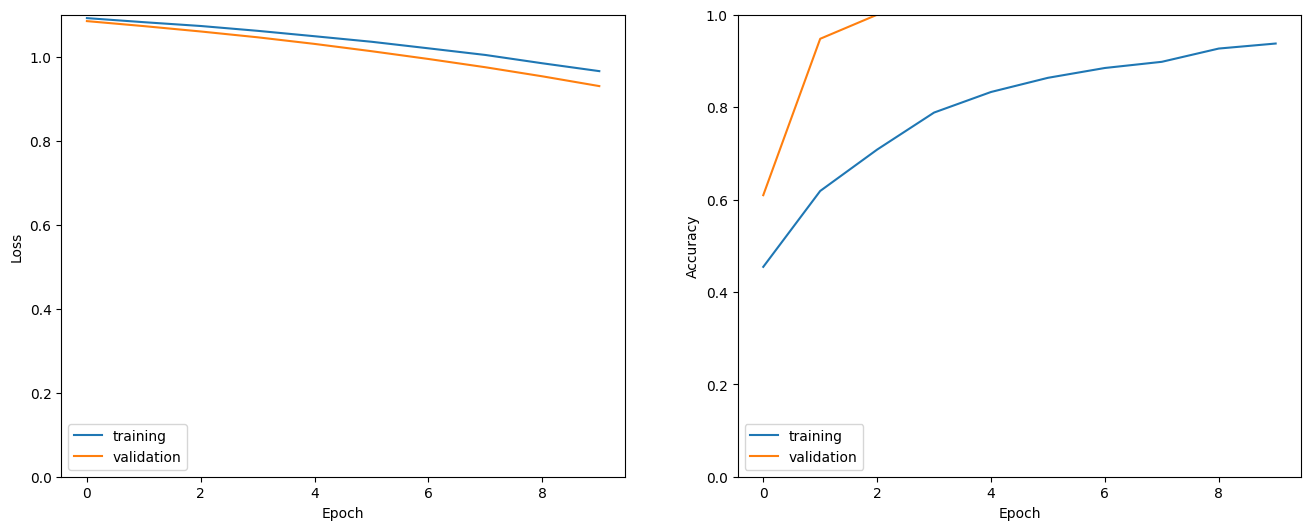

In [43]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [44]:
model.evaluate(test_spectrogram_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.9300 


{'accuracy': 1.0, 'loss': 0.92781662940979}

In [45]:
y_pred = model.predict(test_spectrogram_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


In [46]:
y_pred = tf.argmax(y_pred, axis=1)

In [47]:
y_true = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

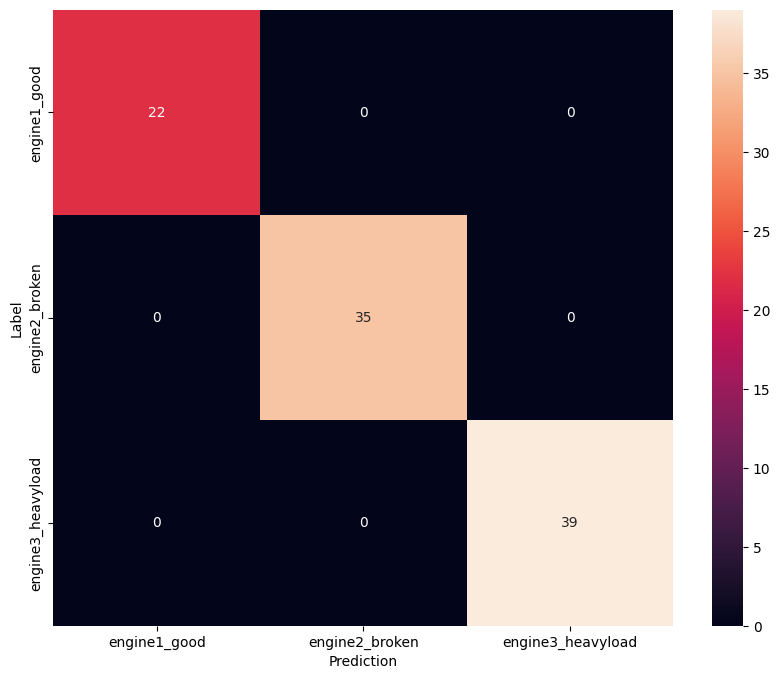

In [48]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **Test the Model on a Completely New Audio File**

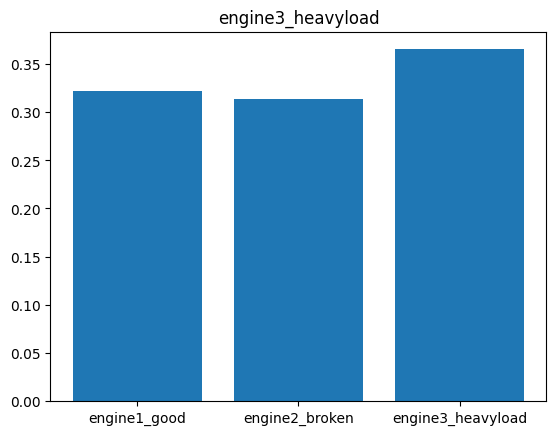

In [49]:
x = '/kaggle/input/electrical-motor-operational-state-sound-data/IDMT-ISA-ELECTRIC-ENGINE/train_cut/engine3_heavyload/pure_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['engine1_good', 'engine2_broken', 'engine3_heavyload']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('engine3_heavyload')
plt.show()

display.display(display.Audio(waveform, rate=16000))

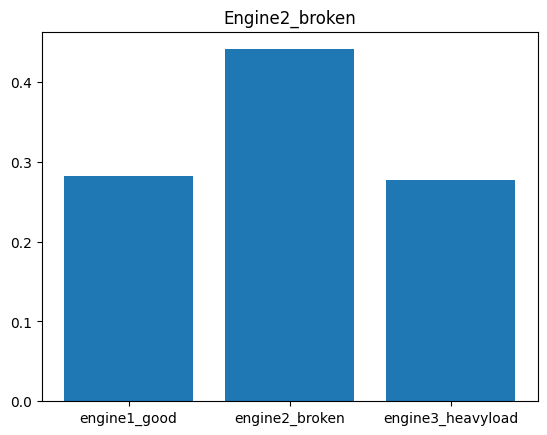

In [50]:
x = '/kaggle/input/electrical-motor-operational-state-sound-data/IDMT-ISA-ELECTRIC-ENGINE/train_cut/engine2_broken/pure_10.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['engine1_good', 'engine2_broken', 'engine3_heavyload']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Engine2_broken')
plt.show()

display.display(display.Audio(waveform, rate=16000))